# Predicting & Model Selection

In this notebook we work on the problem of **overfitting** using the Ozone dataset.

Let's import the packages and load the dataset into a pandas dataframe




In [2]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/ozone.csv')


As before we remove the samples with missing values and rename some of the columns


In [3]:
# drop samples with missing values
df.dropna(inplace = True)
# drop Day and Month columns
df= df.drop(columns = ['Day', 'Month'])
# rename Solar.R as Solar
df = df.rename(columns = {'Solar.R': 'Solar'})

df.head()


,Ozone,Solar,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
6,23.0,299.0,8.6,65


We also build 2 new variables,  square of Wind and square of Temp.

In [4]:
df['Wind2'] = np.square(df['Wind'])
df['Temp2'] = np.square(df['Temp'])



Let's first define a new metric called RMSE for root mean square error
that takes as input the residuals of a model
and which is defined as such.

In [5]:
def RMSE(resid):
    return np.sqrt(np.square(resid).sum()) / len(resid)


The RMSE measures the distance between the fitted values given by the model and the real values of the outcome variable.

The lower the RMSE the better.

Let's now build a series of increasingly complex models, that we store into a list of formulas :


In [6]:
formulas = ['Ozone ~ Temp',
'Ozone ~ Wind',
'Ozone ~ Temp + Temp2',
'Ozone ~ Wind + Wind2',
'Ozone ~ Temp + Wind + Solar',
'Ozone ~ Temp + Temp2 + Wind + Wind2 + Solar'
]


We can loop through each formula, creating and fitting each associated model.

For each model we store the R-squared and the RMSE.


In [7]:
scores = []
for formula in formulas:
    results = smf.ols(formula, df).fit()
    scores.append( { 'model': formula,
        'RMSE':RMSE(results.resid),
        'R-squared': results.rsquared}
    )

scores = pd.DataFrame(scores)


And we see that the more complex the model the better the RMSE and the R-squared


In [8]:
print(scores.sort_values(by = 'RMSE').reset_index(drop = True))


   R-squared      RMSE                                        model
0   0.712308  1.686430  Ozone ~ Temp + Temp2 + Wind + Wind2 + Solar
1   0.605895  1.973832                  Ozone ~ Temp + Wind + Solar
2   0.542627  2.126373                         Ozone ~ Temp + Temp2
3   0.505481  2.211034                         Ozone ~ Wind + Wind2
4   0.487960  2.249862                                 Ozone ~ Temp
5   0.375152  2.485371                                 Ozone ~ Wind


But that does not tell us which model is too complex and is actually overfitting the data.


## Cross-validation

For that we need to split the dataset into a train and a test subset,
use the train subset to fit the model and evaluate its performance on the test subset.


This technique is called **cross validation**

Let's first create the train and test subsets
by taking 70% of the samples for the train subset
and the remaining 30% for the test subset


In [9]:
# take a random sample of 70% of the dataframe
np.random.seed(8)
train_index = df.sample(frac = 0.7).index
# create the train and test subset
train = df.loc[df.index.isin(train_index)]
test = df.loc[~df.index.isin(train_index)]



next we're going to compare the models,
by fitting them on the **train** subset
and calculating the RMSE on the **test** subset

For comparison purposes we also calculate the RMSE on the train subset.


In [10]:
scores = []
for formula in formulas:
    results = smf.ols(formula, train).fit()
    yhat = results.predict(test)
    resid_test = yhat - test.Ozone
    scores.append( { 'model': formula,
        'RMSE_test':RMSE(resid_test),
        'RMSE_train':RMSE(results.resid),
        'R-squared': results.rsquared}
    )

scores = pd.DataFrame(scores)

scores


,R-squared,RMSE_test,RMSE_train,model
0,0.486604,3.747403,2.826150,Ozone ~ Temp
1,0.406033,4.399999,3.039835,Ozone ~ Wind
2,0.521180,3.320133,2.729323,Ozone ~ Temp + Temp2
3,0.569732,4.379300,2.587252,Ozone ~ Wind + Wind2
4,0.632311,3.681170,2.391714,Ozone ~ Temp + Wind + Solar
5,0.755576,3.577426,1.950028,Ozone ~ Temp + Temp2 + Wind + Wind2 + Solar


The following plot shows the RMSE on the train and on the test subsets


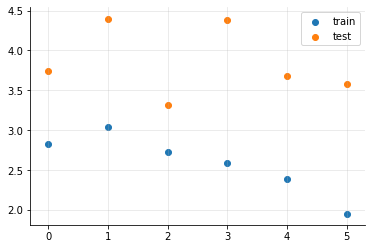

In [12]:
plt.scatter(scores.index, scores.RMSE_train, label = 'train'  )
plt.scatter(scores.index, scores.RMSE_test, label = 'test'  )
plt.grid(alpha = 0.3)
sns.despine()
plt.legend()


We see that the train RMSE tends to get lower and lower
as the model complexity increases
but this not always the case for the test RMSE.

The test RMSE is a good indicator of the capacity of the model
to handle new unseen data,
or in other words, to be able to make predictions on new data.

However, this relative performance of the model
is highly dependent on the way
we split the data into a train and test set
if we set another seed value we will get a different RMSE graph.



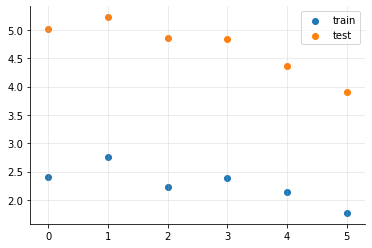

In [14]:
# Same code, different seed
np.random.seed(43)
train_index = df.sample(frac = 0.7).index
# create the train and test subset
train = df.loc[df.index.isin(train_index)]
test = df.loc[~df.index.isin(train_index)]

scores = []
for formula in formulas:
    results = smf.ols(formula, train).fit()
    yhat = results.predict(test)
    resid_test = yhat - test.Ozone
    scores.append( { 'model': formula,
        'RMSE_test':RMSE(resid_test),
        'RMSE_train':RMSE(results.resid),
        'R-squared': results.rsquared}
    )

scores = pd.DataFrame(scores)

plt.scatter(scores.index, scores.RMSE_train, label = 'train'  )
plt.scatter(scores.index, scores.RMSE_test, label = 'test'  )
plt.grid(alpha = 0.3)
sns.despine()
plt.legend()


With a seed of 43 instead of 8, the best performing model in the test is no longer model #2 but model #5


## K fold cross validation
To overcome this dependency on the initialization,
we split the dataset into a train and test subset **several times**,
each time we fit a model and calculate a new RMSE on the test subset
and we average the test RMSE results.

This will give us a more stable way to assess the predicting power of the model.

This technique is called K fold cross validation.


Let's implement K fold cross validation for 4 folds.


In [16]:
K = 4

Let's randomize the data and split it in 4 parts of equal length.

We will use each chunk in turn as the test subset
and the remaining three chunks for the training subset.


In [27]:
np.random.seed(8)

df = df.sample(frac = 1)
indexes = np.array_split(list(df.index),K)


scores = []

for formula in formulas:
    for i in range(K):
        test_index  = indexes[i]
        train_index = [idx for idx in list(df.index) if idx not in test_index]
        train = df.loc[df.index.isin(train_index)]
        test  = df.loc[~df.index.isin(train_index)]

        results = smf.ols(formula, train).fit()
        yhat    = results.predict(test)
        resid_test = yhat - test.Ozone

        scores.append( {
            'model': formula,
            'RMSE_test':RMSE(resid_test),
            'RMSE_train':RMSE(results.resid)
        })

scores = pd.DataFrame(scores)
scores


,RMSE_test,RMSE_train,model
0,2.973519,2.840518,Ozone ~ Temp
1,4.765688,2.546130,Ozone ~ Temp
2,5.662473,2.332073,Ozone ~ Temp
3,4.294425,2.634962,Ozone ~ Temp
4,4.982281,2.891067,Ozone ~ Wind
5,5.070457,2.863245,Ozone ~ Wind
6,5.600313,2.737009,Ozone ~ Wind
7,4.484412,2.951415,Ozone ~ Wind
8,2.470494,2.722656,Ozone ~ Temp + Temp2
9,4.528882,2.399559,Ozone ~ Temp + Temp2


Finally let's calculate the average RMSE obtained per model

In [28]:
scores = scores.groupby(by = 'model').mean().reset_index()

scores

,model,RMSE_test,RMSE_train
0,Ozone ~ Temp,4.424026,2.588421
1,Ozone ~ Temp + Temp2,4.136630,2.445521
2,Ozone ~ Temp + Temp2 + Wind + Wind2 + Solar,3.411099,1.932306
3,Ozone ~ Temp + Wind + Solar,4.021032,2.260937
4,Ozone ~ Wind,5.034366,2.860684
5,Ozone ~ Wind + Wind2,4.526605,2.543117


Comparing the train and test RMSE for the different models


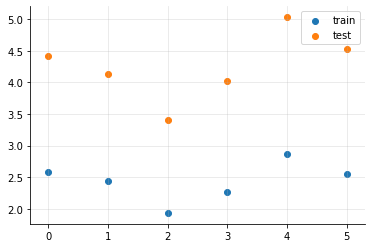

In [29]:
plt.scatter(scores.index, scores.RMSE_train, label = 'train'  )
plt.scatter(scores.index, scores.RMSE_test, label = 'test'  )
plt.grid(alpha = 0.3)
sns.despine()
plt.legend()



You can verify that changing the seed 

```np.random.seed(42)```

will no longer point to another best model

## Overfitting

The best model is the model number 2,
which corresponds to the best RMSE for train and test
This is our most complex dataset.

None of these models tend to overfit the training data.
If one model of these models was overfitting
we would see the testing RMSE increasing
as the training RMSE decreases.

In order to demonstrate overfitting,
we need to consider much more complex models.

So let's create the following variables
which are powers of Wind and Temp and Solar radiation
up to the power of 4


In [30]:
df['Wind3'] = df['Wind']**3
df['Wind4'] = df['Wind']**4

df['Solar2'] = df['Solar']**2
df['Solar3'] = df['Solar']**3
df['Solar4'] = df['Solar']**4

df['Temp3'] = df['Temp']**3
df['Temp4'] = df['Temp']**4


and let's define the following models which are more and more complex.

In [31]:
formulas = [
    'Ozone ~ Solar',
    'Ozone ~ Solar + Solar2',
    'Ozone ~ Wind',
    'Ozone ~ Wind + Wind2',
    'Ozone ~ Temp',
    'Ozone ~ Temp + Temp2',
    'Ozone ~ Temp + Wind + Solar',
    'Ozone ~ Temp + Temp2 + Wind + Wind2 + Solar + Solar2',
    'Ozone ~ Temp + Temp2 + Temp3 + Wind + Wind2 + Wind3 + Solar + Solar2 + Solar3',
    'Ozone ~ Temp + Temp2 + Temp3 + Temp4 + Wind + Wind2 + Wind3 + Wind4 + Solar + Solar2 + Solar3 + Solar4',
    'Ozone ~ Temp + Temp2 + Temp3 + Temp4 + Wind + Wind2 + Wind3 + Wind4 + Solar + Solar2 + Solar3 + Solar4 + Temp * Wind + Temp * Solar + Wind * Solar',
]


we can re-use the same cross validation code as before

In [34]:
scores = []

for formula in formulas:
    for i in range(K):
        test_index  = indexes[i]
        train_index = [idx for idx in list(df.index) if idx not in test_index]
        train = df.loc[df.index.isin(train_index)]
        test  = df.loc[~df.index.isin(train_index)]

        results = smf.ols(formula, train).fit()
        yhat    = results.predict(test)
        resid_test = yhat - test.Ozone

        scores.append( {
            'model': formula,
            'RMSE_test':RMSE(resid_test),
            'RMSE_train':RMSE(results.resid)
        })

scores = pd.DataFrame(scores)
scores = scores.groupby(by = 'model').mean().reset_index()
scores

,model,RMSE_test,RMSE_train
0,Ozone ~ Solar,5.914405,3.396311
1,Ozone ~ Solar + Solar2,5.633636,3.217071
2,Ozone ~ Temp,4.424026,2.588421
3,Ozone ~ Temp + Temp2,4.136630,2.445521
4,Ozone ~ Temp + Temp2 + Temp3 + Temp4 + Wind + ...,3.559855,1.791536
5,Ozone ~ Temp + Temp2 + Temp3 + Temp4 + Wind + ...,3.699036,1.741116
6,Ozone ~ Temp + Temp2 + Temp3 + Wind + Wind2 + ...,3.464913,1.842829
7,Ozone ~ Temp + Temp2 + Wind + Wind2 + Solar + ...,3.414256,1.925928
8,Ozone ~ Temp + Wind + Solar,4.021032,2.260937
9,Ozone ~ Wind,5.034366,2.860684


Let's plot the train and test RMSE for the different models


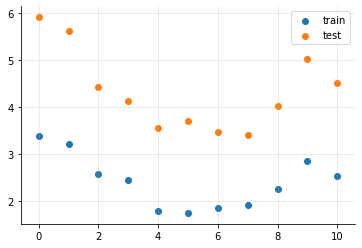

In [35]:
plt.scatter(scores.index, scores.RMSE_train, label = 'train'  )
plt.scatter(scores.index, scores.RMSE_test, label = 'test'  )
plt.grid(alpha = 0.3)
sns.despine()
plt.legend()


we see that

- model 5 has the lowest train RMSE but not the lowest **test** RMSE
that model is **overfitting**

- model 7 on the other hand has the lower test RMSE. That model would therefore be the best choice to make predictions on new unseen data.
